<a href="https://colab.research.google.com/github/gcarmonav/gcarmonav.github.io/blob/main/Copia_de_Regresion_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Actividad 03: Regresión - Predicción del precio de la vivienda en Taiwan

Por:

Giovanna Carmona Valencia

Hilber García López

##Indice
- Planteamiento del problema

- Resultados

- Referencias

##Planteamiento del problema

El objetivo de este trabajo encontrar el mejor modelo de regresión que pueda capturar mejor la relación entre el precio de la vivienda en Taiwan y las características propias de esta. Adicionalmente se busca establecer qué características tiene un mayor impacto en el precio de la vivienda.

En este ejercicio, se plantearán los siguientes métodos:

- Regresión lineal (clásica y elastic net)
- Ensambles de árboles: bosques aleatorios y XGBoost
- Máquinas de soporte vectorial
- Redes neuronales


##Selección de hiperparámetros
En este ejercicio se usará a clase Grid Search de Scikit-learn que permite evaluar y seleccionar de forma sistemática los parámetros de un modelo. Esta clase puede evaluar el rendimiento del modelo en función de los parámetros mediante valización cruzada.

##Importación de librerias

In [ ]:
import numpy as np
from numpy import arange
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import multiprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import keras.backend as K


## Base de datos

El conjunto de datos de valoración de bienes raíces fue tomado del repositorio UCI y el propietario de origen de este conjunto de datos es el profesor Prof. I-Cheng Yeh de la Universidad de TamKang. 

Esta base de datos contiene datos históricos del mercado inmobiliario de 2012 a 2013, distrito de Sindian, ciudad de New Taipei, esta se encuentra compuesta por siete (7) variables numericas y 414 observaciones de venta de propiedades. De manera específica, las variables son:

- X1: fecha de la transacción (por ejemplo 2013.250=2013 Marzo, * 2013.500=2013 Junio, etc.)
- X2: edad de la casa en años
- X3: distancial al MRT (transporte masivo) más cercano en metros
- X4: número de tiendas de conveniencia en el vecindario (entero)
- X5: latitud (unidad: grados)
- X6: longitude (unidad: grados)
- Y: precio por unidad de área (10000 Nuevos dólares taiwaneses/ 3.3 m2)

In [ ]:
# Importar la librería de Drive en Colab y montar la unidad.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Regresion/real_estate_valuation_dataset.csv', sep=';',decimal=',')

In [ ]:
dataset.head()

,No,X1,X2,X3,X4,X5,X6,Y
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [ ]:
dataset.info()
dataset.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      414 non-null    int64  
 1   X1      414 non-null    float64
 2   X2      414 non-null    float64
 3   X3      414 non-null    float64
 4   X4      414 non-null    int64  
 5   X5      414 non-null    float64
 6   X6      414 non-null    float64
 7   Y       414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


,No,X1,X2,X3,X4,X5,X6,Y
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


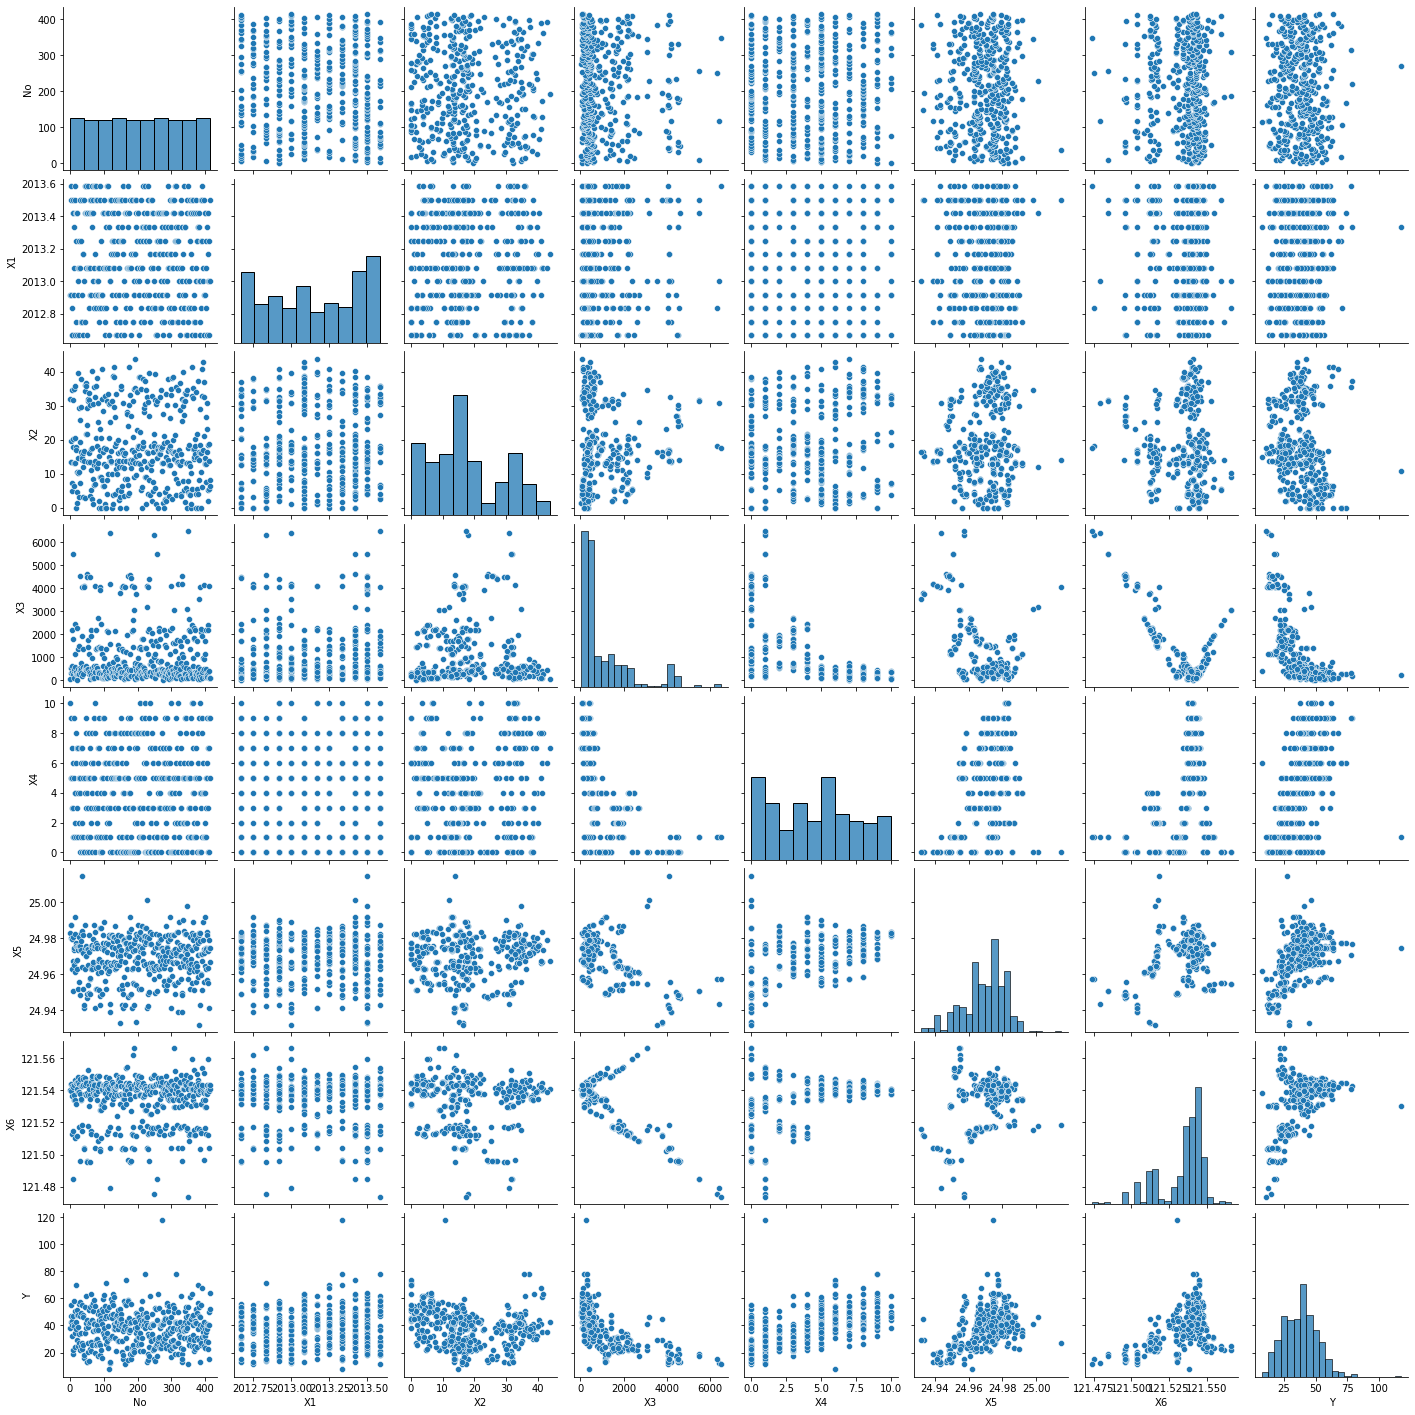

In [ ]:
sns.pairplot(dataset)

In [ ]:
dataset_corr = dataset.corr()

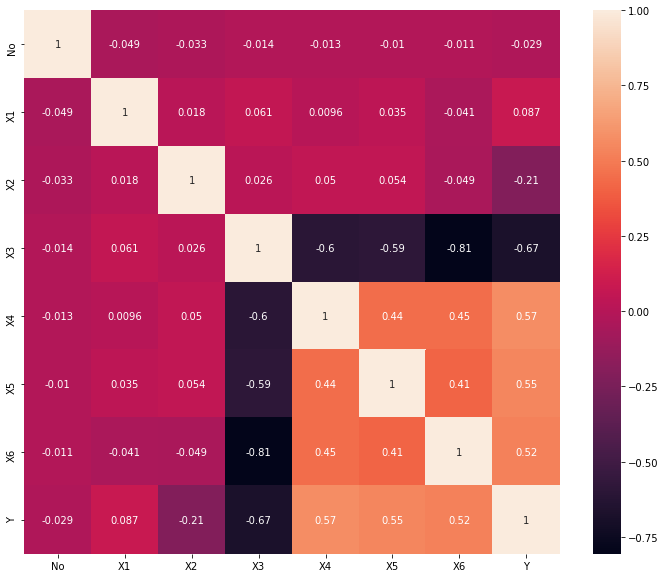

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(dataset_corr, annot=True);

Depuramos los datos, dejando las variables más correlacionadas y las que se encuentran relacionadas directamente al precio de la casa, las cuales serían:

X2: edad de la casa en años

X3: distancia al MRT (transporte masivo) más cercano en metros

X4: número de tiendas de conveniencia en el vecindario (entero)

Y: precio por unidad de área (10000 Nuevos dólares taiwaneses/ 3.3 m2)



In [ ]:
data_dep = dataset.iloc[:,[2,3,4,7]]
data_dep.head()

,X2,X3,X4,Y
0,32.0,84.87882,10,37.9
1,19.5,306.59470,9,42.2
2,13.3,561.98450,5,47.3
3,13.3,561.98450,5,54.8
4,5.0,390.56840,5,43.1


In [ ]:
data_dep.info()
data_dep.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X2      414 non-null    float64
 1   X3      414 non-null    float64
 2   X4      414 non-null    int64  
 3   Y       414 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 13.1 KB


,X2,X3,X4,Y
count,414.000000,414.000000,414.000000,414.000000
mean,17.712560,1083.885689,4.094203,37.980193
std,11.392485,1262.109595,2.945562,13.606488
min,0.000000,23.382840,0.000000,7.600000
25%,9.025000,289.324800,1.000000,27.700000
50%,16.100000,492.231300,4.000000,38.450000
75%,28.150000,1454.279000,6.000000,46.600000
max,43.800000,6488.021000,10.000000,117.500000


Veamos los diagramas de dispersión de todas las variables a través de la función pairplot:

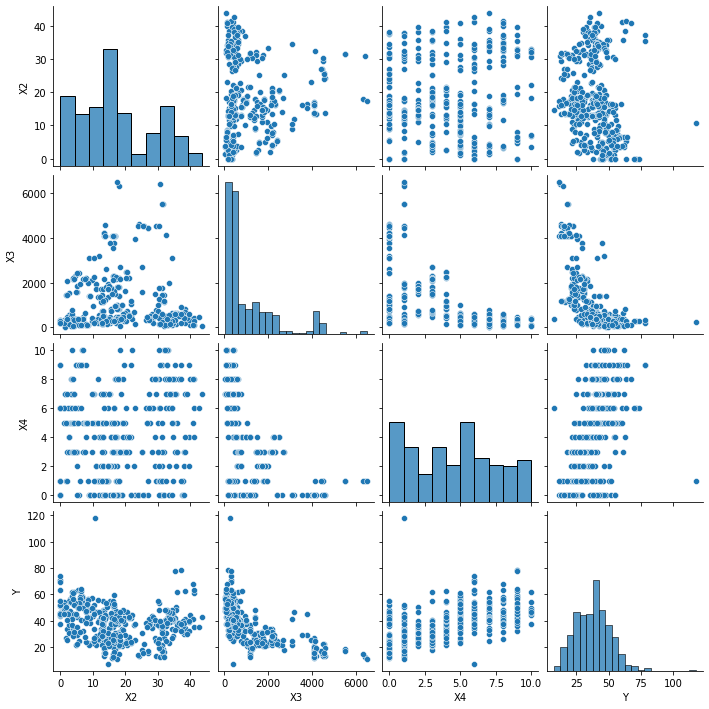

In [ ]:
sns.pairplot(data_dep)

In [ ]:
data_dep_corr = data_dep.corr()

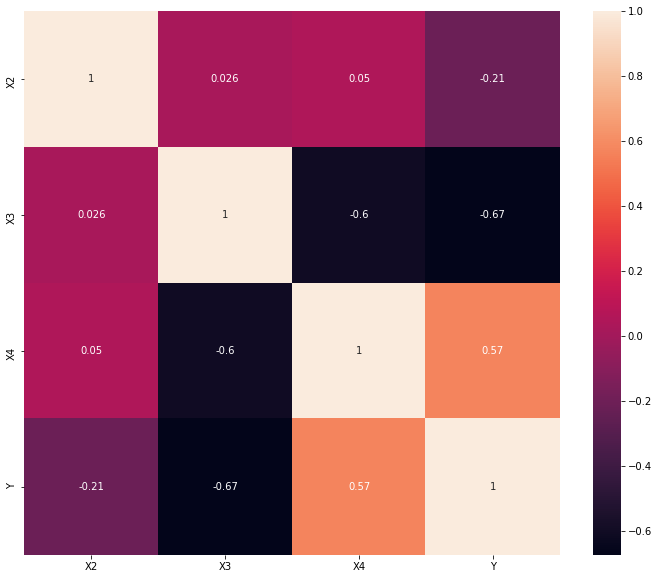

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(data_dep_corr, annot=True);

De acuerdo a la matriz de correlación, observamos que la correlación entre X3 y Y es negativa y es relativamente fuerte. Lo cual significa que mientras más alejada se encuentra la casa del medio de transporte más disminuye su precio, asimismo mientras más tiendas existan en el sector el precio de la casa aumenta con lo cual su correlación es positiva.

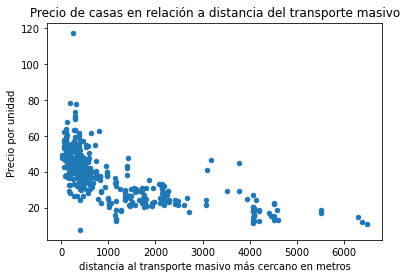

In [ ]:
#Generamos una gráfica de dispersión de la variable x3 respecto a Y
data_dep.plot(
    kind = 'scatter', 
    x = 'X3',
    y = 'Y',
)
plt.title('Precio de casas en relación a distancia del transporte masivo')
plt.xlabel('distancia al transporte masivo más cercano en metros')
plt.ylabel('Precio por unidad ')

plt.show()


Como se dijo anteriormente,en la gráfica se puede observar que los precios por unidad más altos se presentan cuando la distancia en metros es más baja, es decir cuando la vivienda se encuentra más cerca al servicio de transporte masivo. De la misma manera a medida que se incrementa la distancia en metros de la vivienda al servicio de transporte masivo los precios de son más bajos.

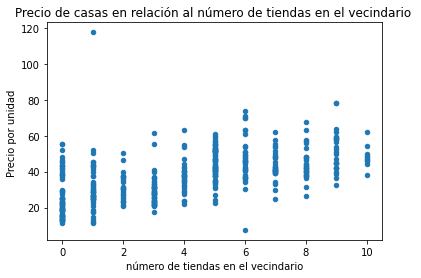

In [ ]:
#Generamos una gráfica de dispersión de la variable x4 respecto a Y
data_dep.plot(
    kind = 'scatter', 
    x = 'X4',
    y = 'Y',
)
plt.title('Precio de casas en relación al número de tiendas en el vecindario ')
plt.xlabel('número de tiendas en el vecindario')
plt.ylabel('Precio por unidad ')

plt.show()


Si bien la variable de número de tiendas en el vecindario tiene una correlación positiva con el precio de las viviendas, de manera gráfica no se logra apreciar esta tendencia, en términos generales algunas de las casas con 6 a 9 tiendas en el vecindario tienen un precio más alto. Si analizamos el menor precio de las casas se observa que a medida que se incrementa el número de tiendas este sube un poco.

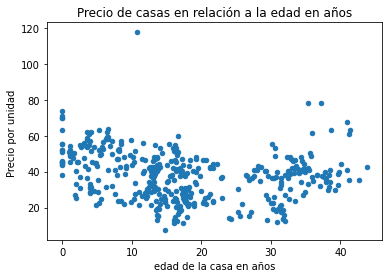

In [ ]:
#Generamos una gráfica de dispersión de la variable x4 respecto a Y
data_dep.plot(
    kind = 'scatter', 
    x = 'X2',
    y = 'Y',
)
plt.title('Precio de casas en relación a la edad en años')
plt.xlabel('edad de la casa en años')
plt.ylabel('Precio por unidad ')

plt.show()


De acuerfo a la gráfica, en la parte izquierda se puede apreciar que algunas de las casas más nuevas tienen precios más altos, sin embargo, tambien se observa (aunque en menor medida) casas con entre 30 y 40 años que tienen precios altos.

#Normalización de la información

Dada la distribucción de las variables, lo mejor es normalizar la base de datos, para esto se utilizará la función 'normalize'

In [ ]:
#Se normaliza la base de datos con las variables seleccionadas

data_nor = preprocessing.normalize(data_dep)
data_nor = pd.DataFrame(data_nor)
data_nor.columns=data_dep.columns
data_nor

,X2,X3,X4,Y
0,0.323831,0.858948,0.101197,0.383537
1,0.062857,0.988283,0.029011,0.136028
2,0.023575,0.996161,0.008863,0.083843
3,0.023547,0.994964,0.008852,0.097021
4,0.012723,0.993805,0.012723,0.109668
...,...,...,...,...
409,0.003356,0.999987,0.000000,0.003773
410,0.053899,0.870629,0.086624,0.481244
411,0.047766,0.993359,0.017785,0.103155
412,0.068872,0.891170,0.042514,0.446392


#Métodos de regresión

##Separación en datos de entramiento y evaluación

Se separan las variables independientes correspondientes a las características de las casas de la variable dependiente correspondiente al precio de venta. Para el ejercicio se maneja una proporción del 30% para la muestra de prueba y una random_state que permite la reproducibilidad de la extracción


In [ ]:
X = data_nor.iloc[:, 0:-1]
y = data_dep.iloc[:, -1] #La variable dependiente no se normaliza por esto se toma de la base de datos antes de aplicar la normalización

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape) 

(289, 3) (289,)
(125, 3) (125,)


##Regresión Elastic Net

Elastic Net es un modelo de regresión lineal que normaliza el vector de coeficientes con las normas L1 y L2, lo cual permite generar un modelo en el que solo algunos de los coeficientes sean no nulos, manteniendo las propiedades de regularización de Ridge.

Dado que en su formulario incorpora el parámetro λ regula el peso dado a la regularización impuesta por Ridge y por Lasso, por lo tanto se considera como un conjunto de ambos modelos.

Los hiperparametros de este modelo son:

- alpha:  regula la penalización a los pesos del modelo, por lo
que, intuitivamente, cuanto mayor sea el valor de este parámetro menos características serán seleccionadas para el modelo. 

- l1_ratio: corresponde a la combinación entre la regularización Lasso y Ridge, tiene que tomar un valor en 0 y 1, el valor es elegido entre 0.1 y 0.8, puesto que un valor de 0 supondría una regresión Ridge y
un valor de 1 sería el caso de Lasso




In [ ]:
#Se crea el modelo
model = ElasticNet()

In [ ]:
# Se define el metodo de evaluación del modelo
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
# Se define el grid con los hiperparámetros
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)

In [ ]:
# Se define el parámetro search del modelo
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

In [ ]:
# Se realiza la búsqueda del modelo 
resultsen = search.fit(X = X_train, y = y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20425.92237999771, tolerance: 5.503906110726644
  positive)


In [ ]:
#A continuación se detallan los hiperparámetros que generan un mejor resultado para la métrica 'neg_root_mean_squared_error', junto con los 
#Resultados del modelo de regresión Elastic Net
resultadosen = pd.DataFrame(resultsen.cv_results_)
resultadosen.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_alpha,param_l1_ratio,mean_test_score,std_test_score
548,0,0.48,-11.857375,3.272612


In [ ]:
# Error de test del modelo final

modelo_final_en = resultsen.best_estimator_
predicciones_en = resultsen.predict(X = X_test)
rmse_en = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_en,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse_en}")

El error (rmse) de test es: 10.972876595030703


Las predicciones del modelo Elastic Net se alejan en promedio 10.97 unidades del valor real.


##Regresión lineal

La regresión lineal simple consiste en generar un modelo de regresión (ecuación de una recta) que permita explicar la relación lineal que existe entre las variables. A la variable dependiente o respuesta se le identifica como Y y a las variables predictoras o independientes como X. 

Los hiperparámetros de este modelo son:

-  fit_intercept: True/False, para quedar o quitar la constante β₀ de nuestro modelo. (si se quita la recta pasará obligatoriamente por el punto 0 del eje de abscisas).

- normalize: True/False, para normalizar los datos o no, normalmente la regresión lineal suele funcionar mejor con datos normalizados, para que todas las variables estén a la misma escala.

In [ ]:
#Instanciamos el modelo
lm = LinearRegression(fit_intercept=True, normalize=False)

In [ ]:
# Se realiza la búsqueda del modelo 
lm.fit(X_train, y_train)#Predecimos en train y test

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#Se realizan las métricas para comprobar lo bueno que es el modelo
predictions_train = lm.predict(X_train)
predictions_test = lm.predict(X_test)

In [ ]:
#Se imprimen los resultados de las metricas del modelo
print(mean_absolute_error(predictions_train, y_train))
print(np.sqrt(mean_squared_error(predictions_train, y_train)))
print(mean_absolute_error(predictions_test, y_test))
print(np.sqrt(mean_squared_error(predictions_test, y_test)))
print(r2_score(predictions_train, y_train))
print(r2_score(predictions_test, y_test))

8.789187221820292
11.889317231087642
8.392957614809363
10.972876595030705
-1.8794827512342542
-2.3347023521602384


In [ ]:
# Se cálcula el error de test del modelo 

predicciones_lm = lm.predict(X = X_test)
print(predicciones[0:3,])

rmse_ln = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_lm,
        squared = False
       )
print("")
print(f"El error (rmse_ln) de test es: {rmse_ln}")

[33.71695382 33.2220245  38.99441245]

El error (rmse_ln) de test es: 10.972876595030705


Las predicciones del modelo de regresión lineal se alejan en promedio 10.97 unidades del valor real, al igual que el modelo de regresión Elastic Net.

In [ ]:
#Se cálcula el máximo y el mínimo del valor de y para determinar si el RMSE es alto o bajo, de acuerdo con los resultados, es valor es bajo respecto a los datos 
print(np.min(data_dep['Y']))
print(np.max(data_dep['Y']))

7.6
117.5


In [ ]:
# dado que el modelo de regresión lineal permite extraer los coeficientes para determinar la importancia de las variables, se cálculan los coeficientes
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient']) 
coeff_df

,Coefficient
X2,-8.839124
X3,42.396217
X4,401.783870


De acuerdo con el anterior resultado, para el modelo de regresión lineal, la valiable X4 correspondiente a las tiendas cercanas a la vecindad y en segundo lugar la variable X3 correspondiente a los metros de cercanía con el sistema de transporte masivo son las variables que tienen mayor impacto en el precio de la vivienda.

## Regresión lineal (Ridge)



Ridge es una regularización de la regresión lineal que penaliza la suma de los coeficientes elevados al cuadrado. A esta penalización se le conoce como l2 y tiene el efecto de reducir de forma proporcional el valor de todos los coeficientes del modelo pero sin que estos lleguen a cero. 

Este método sirve de ayuda cuando sse sospecha que varios de las variables de entrada estén correlacionados entre si. Ridge hace que los coeficientes acaben siendo más pequeños. Esta disminución de los coeficientes minimiza el efecto de la correlación entre los atributos de entrada y hace que el modelo generalice mejor. Ridge funciona mejor cuando la mayoría de los atributos son relevantes.

Los hiperparámetros de este modelo son:

- solver: es el solucionador que se va usar en las rutinas computacionales: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}

  i. 'auto' elige el solucionador automáticamente según el tipo de datos.

  ii. 'svd' usa una descomposición de valores singulares de X para calcular los coeficientes de cresta. Más estable para matrices singulares que 'cholesky'.

  iii. 'cholesky' usa la función estándar scipy.linalg.solve para obtener una solución de forma cerrada.
  
  iv. 'sparse_cg' usa el solucionador de gradiente conjugado que se encuentra en scipy.sparse.linalg.cg. Como algoritmo iterativo, este solucionador es más apropiado que 'cholesky' para datos a gran escala (posibilidad de establecer tol y max_iter).
  
  v.'lsqr' usa la rutina dedicada de mínimos cuadrados regularizados scipy.sparse.linalg.lsqr. Es el más antiguo, pero puede que no esté disponible en versiones antiguas de scipy. También utiliza un procedimiento iterativo.
  
  vi.'sag' utiliza un descenso de gradiente medio estocástico. 

- alpha: determina la fuerza de regularización. Cuanto mayor sea el valor de alfa, más fuerte será la regularización. En otras palabras, cuando alfa es un número mucho mayor, el sesgo del modelo será alto. Un alfa de 1 dará como resultado un modelo que actúa de manera idéntica a la regresión lineal. 

In [ ]:
#Se define el modelo
model = Ridge()

In [ ]:
# Se define la evaluación del modelo
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
# Se define las opciones de los hiperparámetros del modelo
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]

In [ ]:
# Se define el parámetro search del modelo
search1 = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)

In [ ]:
# Se realiza la búsqueda del modelo 
resultrl = search1.fit(X = X_train, y = y_train)

In [ ]:
#A continuación se detallan los hiperparámetros que generan un mejor resultado para la métrica 'neg_root_mean_squared_error', junto con los 
#Resultados del modelo de regresión lineal Ridge
resultadosrl = pd.DataFrame(resultrl.cv_results_)
resultadosrl.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_alpha,param_fit_intercept,param_normalize,param_solver,mean_test_score,std_test_score
27,0.0001,False,True,sag,-11.62174,2.978361


In [ ]:
# Se cálcula el error de test del modelo final

modelo_final = resultrl.best_estimator_
predicciones_lmr = modelo_final.predict(X = X_test)

rmse_lmr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones_lmr,
            squared = False
          )
print(f"El error (rmse_lmr) de test es: {rmse_lmr}")

El error (rmse_lmr) de test es: 10.967629526061955


Las predicciones del modelo de regresión lineal con regularización Ridge se alejan en promedio 10.97 unidades del valor real.

##Ramdom forest

Random Forest es un técnica de aprendizaje automático supervisada basada en árboles de decisión. Su principal ventaja es que obtiene un mejor rendimiento de generalización para un rendimiento durante entrenamiento similar. Esta mejora en la generalización la consigue compensando los errores de las predicciones de los distintos árboles de decisión. 

Los hiperparámetros en este modelo son:

- n_estimators: número de árboles que va a tener el bosque aleatorio. Normalmente cuantos más mejor, pero a partir de cierto punto deja de mejorar y sólo hace que vaya más lento. 
- n_jobs: número de cores que se pueden usar para entrenar los árboles.
- max_features: corresponde al máximo de atributos que se pueden usar en el modelo.

Regularización:
- max_depth: la profundidad máxima del árbol.
- min_samples_split: número mínimo de muestras necesarias antes de dividir el nodo.
- min_samples_leaf: número mínimo de muestras que debe haber en un nodo final (hoja).
- max_leaf_nodes: número máximo de nodos finales


In [ ]:
# Se crean los parametros del grid basado en los resultados del random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}

In [ ]:
# Búsqueda por grid search con validación cruzada de acuerdo a los anteriores parámetros

gridrf = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )


In [ ]:
# Se realiza la búsqueda del modelo 
gridrf.fit(X = X_train, y = y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=...
                                             oob_score=False, random_state=123,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=1,
    

In [ ]:
#A continuación se detallan los hiperparámetros que generan un mejor resultado para la métrica 'neg_root_mean_squared_error', junto con los 
#Resultados del modelo de regresión Random Forest

resultadosrf = pd.DataFrame(gridrf.cv_results_)
resultadosrf.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
110,True,90,3,3,8,300,-6.920925,2.051976,-4.83139,0.527713


In [ ]:
# Error de test del modelo final

modelo_final_rf = gridrf.best_estimator_
predicciones_rf = modelo_final_rf.predict(X = X_test)

rmse_rf = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_rf,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse_rf}")

El error (rmse) de test es: 6.1357484858041635


Las predicciones de la regresión con Random Forest se alejan en promedio 6.13 unidades del valor real.

##XGBoost

Este algoritmo hace parte de la familia de árboles (árbol de decisiones, bosque aleatorio, ensacado, impulso, aumento de gradiente). 

El modelo funciona bien incluso con valores perdidos o muchos valores cero con conciencia de la dispersión. XGBoost utiliza un algoritmo llamado "algoritmo de boceto cuantílico ponderado", esto permite que el algoritmo se centre en los datos que están mal clasificados. El algoritmo determina automáticamente el número de iteraciones para el proceso de refuerzo con un método de validación cruzada integrado.

Los hiperparámetros de este modelo son:

- max_depth: es la profundidad máxima del árbol y también se usa para evitar el sobreajuste. Cuanto mayor sea max_depth, el modelo aprenderá muestras más específicas y locales.
- subsample: controla la proporción de muestreo aleatorio para cada árbol. La reducción del valor de este parámetro hace que el algoritmo sea más conservador y evitará el sobreajuste.
- learning_rate: controla la velocidad de aprendizaje, es decir, la velocidad a la que nuestro modelo aprende patrones en los datos. 
- booster: establece el tipo de refuerzo y puede ser: i. gbtree: modelo basado en árbol o ii.gbliner: modelo lineal


In [ ]:
# Se generan los hiperparámetros del modelo

param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree']
             }

In [ ]:
# XGBoost necesita pasar los paramétros específicos del entrenamiento al llamar al método .fit()

fit_params = {"early_stopping_rounds" : 5, 
              "eval_metric"           : "rmse", 
              "eval_set"              : [(X_test, y_test)],
              "verbose"               : 0
             }

In [ ]:
# Búsqueda por grid search con validación cruzada

grid_xg = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators = 1000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_xg.fit(X = X_train, y = y_train, **fit_params)


[01:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[01:03:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[01:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[01:04:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=123),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1000, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=123,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=1,
             param_grid={'booster': ['gbtree'],
                

In [ ]:
#A continuación se detallan los hiperparámetros que generan un mejor resultado para la métrica 'neg_root_mean_squared_error', junto con los 
#Resultados del modelo de regresión utilizando XGBoost

resultados_xg = pd.DataFrame(grid_xg.cv_results_)
resultados_xg.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(1)


,param_booster,param_learning_rate,param_max_depth,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
20,gbtree,0.01,10,0.5,-6.744865,1.276177,-3.307568,0.592688


In [ ]:
# Número de árboles del modelo final (early stopping)

n_arboles_incluidos = len(grid_xg.best_estimator_.get_booster().get_dump())
print(f"Número de árboles incluidos en el modelo: {n_arboles_incluidos}")


Número de árboles incluidos en el modelo: 439


In [ ]:
# Error de test del modelo final

modelo_final_xg = grid_xg.best_estimator_
predicciones_xg = modelo_final_xg.predict(data = X_test)
rmse_xg = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_xg,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse_xg}")

El error (rmse) de test es: 5.297272588281


Las predicciones del modelo XGBoost se alejan en promedio 5.29 unidades del valor real.

##Máquinas de soporte vectorial



Este método fue desarrollado en la década de los 90, dentro de campo de la ciencia computacional. Si bien originariamente se desarrolló como un método de clasificación binaria, su aplicación se ha extendido a problemas de clasificación múltiple y regresión.

Las Máquinas de Vector Soporte se fundamentan en el Maximal Margin Classifier, que a su vez, se basa en el concepto de hiperplano.

Los hiperparámetros del modelo SVM son:

- kernel: es el tipo de kernel que se utilizará, los valores más comunes son rbf, poli, linear o sigmoide, pero también puede crear su propio núcleo.
- C: corresponden al parámetro de regularización y corresponde a la optimización de SVM cuánto desea evitar perder la clasificación de cada ejemplo de entrenamiento.(Si la C es más alta, la optimización elegirá un hiperplano de margen más pequeño, por lo que la tasa de clasificación de pérdida de datos de entrenamiento será menor. Si la C es baja, entonces el margen será grande)
- gamma: define hasta dónde llega la influencia de un solo ejemplo de entrenamiento. La Gamma alta considerará solo los puntos cercanos al hiperplano plausible y la Gamma baja considerará los puntos a mayor distancia. 
- epsilon: permite definir la anchura de la zona insensible de la función de pérdida


In [ ]:
# Se crean los parametros del grid basado en los resultados del modelo SVM 

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [1, 10],
    'gamma': [1e-7, 1e-4],
    'epsilon':[0.1,0.2,0.5,0.3]}


In [ ]:
# Búsqueda por grid search con validación cruzada de acuerdo a los anteriores parámetros

grid_svm = GridSearchCV(
        estimator  = SVR(),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

In [ ]:
# Se realiza la búsqueda del modelo 
grid_svm.fit(X = X_train, y = y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=1,
             param_grid={'C': [1, 10], 'epsilon': [0.1, 0.2, 0.5, 0.3],
                         'gamma': [1e-07, 0.0001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)

In [ ]:
#A continuación se detallan los hiperparámetros que generan un mejor resultado para la métrica 'neg_root_mean_squared_error', junto con los 
#Resultados del modelo de regresión Máquina de Soporte Vectorial

resultados_svm = pd.DataFrame(grid_svm.cv_results_)
resultados_svm.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(1)

,param_C,param_epsilon,param_gamma,param_kernel,mean_test_score,std_test_score,mean_train_score,std_train_score
60,10,0.3,0.0001,linear,-12.819058,1.889056,-12.874901,0.507294


In [ ]:
# Error de test del modelo final

modelo_final = grid_svm.best_estimator_
predicciones = grid_svm.predict(X = X_test)
rmse_svm = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse_svm}")

El error (rmse) de test es: 12.118120190594759


Las predicciones del modelo XGBoost se alejan en promedio 12.12 unidades del valor real.

##Redes neuronales 



Las Redes Neuronales (NN: Neural Networks) fueron originalmente una simulación abstracta de los sistemas nerviosos biológicos, constituidos por un conjunto de unidades llamadas neuronas o nodos conectados unos con otros.

Los parámetros de este modelo son:

- Número de neuronas de la capa oculta: Generalmente un aumento de neuronas ocultas aumenta la eficacia del aprendizaje
- Número de capas ocultas: Un aumento del número de capas de neuronas ocultas se traduce en un cambio en la estructura de la red, pudiéndose obtener resultados diferentes.
- Número de iteraciones: Un número elevado de ellas significa un entrenamiento lento.
- Tasa de aprendizaje: es la encargada de acelerar el proceso de aprendizaje. Se suelen escoger valores pequeños, empezando con una tasa constante.
- Momento: Contrarresta las posibles inestabilidades que se crean en la variación de los pesos, y es importante porque reduce la posibilidad de caer en un mínimo local, además puede acelerar enormemente el proceso.

In [ ]:
#Se define el modelo
model = Sequential()
model.add(Dense(7, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])  # se Compila el modelo

In [ ]:
#Se ajusta el modelo
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
10/10 [==============================] - 1s 2ms/step - loss: 1662.0340 - mean_squared_error: 1662.0340
Epoch 2/20
10/10 [==============================] - 0s 2ms/step - loss: 1651.3692 - mean_squared_error: 1651.3692
Epoch 3/20
10/10 [==============================] - 0s 2ms/step - loss: 1689.0749 - mean_squared_error: 1689.0749
Epoch 4/20
10/10 [==============================] - 0s 1ms/step - loss: 1638.7923 - mean_squared_error: 1638.7923
Epoch 5/20
10/10 [==============================] - 0s 1ms/step - loss: 1694.8701 - mean_squared_error: 1694.8701
Epoch 6/20
10/10 [==============================] - 0s 1ms/step - loss: 1661.0454 - mean_squared_error: 1661.0454
Epoch 7/20
10/10 [==============================] - 0s 1ms/step - loss: 1577.6286 - mean_squared_error: 1577.6286
Epoch 8/20
10/10 [==============================] - 0s 2ms/step - loss: 1662.9232 - mean_squared_error: 1662.9232
Epoch 9/20
10/10 [==============================] - 0s 2ms/step - loss: 1620.6955 - mean

In [ ]:
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

39.8756914137965
38.519076554662725


In [ ]:
rmse_rn = np.sqrt(mean_squared_error(y_test,pred))

print(f"El error (rmse) de test es: {rmse_rn}")

El error (rmse) de test es: 38.519076554662725


Las predicciones del modelo de redes neuronales se alejan en promedio 38.51 unidades del valor real. Este modelo requiere de la optimización de los hiperparámetros

##Resultados

1. ¿Cuál es el mejor modelo entre los usados para resolver este problema? ¿Qué criterios se pueden utilizar para responder a esta pregunta?

Para evaluar los modelo de regresión vistos se utilizará el error cuadrático medio, este representa la desviación estándar de la muestra de las diferencias entre los valores pronosticados y los valores observados. 

El RMSE es la métrica más utilizada para tareas de regresión y es la raíz cuadrada de la diferencia cuadrática promedio entre el valor objetivo y el valor predicho por el modelo. Este se selecciona porque no se desean errores grandes.


In [ ]:
print(f"El error RMSE de test de la regresión lineal es: {rmse_ln}")
print(f"El error RMSE de test del modelo Elastic Net es: {rmse_en}")
print(f"El error RMSE de test del modelo Random Forest  es: {rmse_rf}")
print(f"El error RMSE de test del modelo XG Boost es: {rmse_xg}")
print(f"El error RMSE de test del modelo Máquinas de Soporte Vectorial es: {rmse_svm}")
print(f"El error RMSE de test de las redes neuronales es: {rmse_rn}")


El error RMSE de test de la regresión lineal es: 10.972876595030705
El error RMSE de test del modelo Elastic Net es: 10.972876595030703
El error RMSE de test del modelo Random Forest  es: 6.1357484858041635
El error RMSE de test del modelo XG Boost es: 5.297272588281
El error RMSE de test del modelo Máquinas de Soporte Vectorial es: 12.118120190594759
El error RMSE de test de las redes neuronales es: 38.519076554662725


De acuerdo a la métrica RMSE el mejor modelo para predecir el precio de las viviendas es el XGBoost, el cuál a su vez también tiene el menor error absoluto medio (MAE).

2. ¿Qué variables tienen el mayor impacto en el precio de la vivienda? ¿Cómo aporta cada modelo al conocimiento de este impacto?



In [ ]:
#Coeficientes del modelo de regresión lineal
coeff_df

,Coefficient
X2,-8.839124
X3,42.396217
X4,401.783870


Por su facilidad de cálculo se utilizará el método de regresión lineal para establecer el peso de las variables. De acuerdo a los anteriores resultados, la variable X4 correspondiente a las tiendas cercanas a la vecindad y en segundo lugar la variable X3 correspondiente a los metros de cercanía con el sistema de transporte masivo son las variables que tienen mayor impacto en el precio de la vivienda.

##Referencias

https://aprendeia.com/maquina-de-vectores-de-soporte-regresion-practica-con-python/

https://heartbeat.fritz.ai/support-vector-regression-in-python-using-scikit-learn-89cc18e933b7

https://www.rpubs.com/sngan/517214

https://sitiobigdata.com/2018/08/27/machine-learning-metricas-regresion-mse/

https://unipython.com/regresion-redes-neuronales/

https://coderhook.github.io/Descriptive%20Statistics

https://www.kaggle.com/gova26/linear-regression-on-real-estate-data-set

https://machinelearningmastery.com/xgboost-for-regression/